In [1]:
import tensorflow as tf
print (tf.__version__)

2.3.0


In [2]:
tf.keras.backend.clear_session()

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
project_path = '/content/drive/My Drive/DogBreed_Classification/'

In [6]:
from zipfile import ZipFile
with ZipFile(project_path+'train.zip','r') as z:
  z.extractall()

In [7]:
labels = pd.read_csv(project_path+'labels.csv.zip')
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [8]:
IMG_SIZE=224
channels=3

In [9]:
from tqdm import tqdm
import cv2
features=[]
label=[]

for f, img in tqdm(labels.values): #f for image id, img for dog breed
  #train_img = tf.io.read_file('./train/{}.jpg'.format(f))
  #train_img = tf.image.decode_jpeg(train_img, channels=channels)
  #train_img = tf.image.convert_image_dtype(train_img, tf.float32)
  #train_img_resize = tf.image.resize(train_img, size=[IMG_SIZE, IMG_SIZE])
  
  #Using cv2.imread results in BGR images, instead of the standard RGB as below
  train_img = cv2.imread('./train/{}.jpg'.format(f),1) #0 for grayscale & 1 for color (o/p is bgr)
  train_img_resize = cv2.resize(train_img, (IMG_SIZE,IMG_SIZE))
  features.append(train_img_resize)
  label.append(img)

100%|██████████| 10222/10222 [00:33<00:00, 302.10it/s]


boston_bull


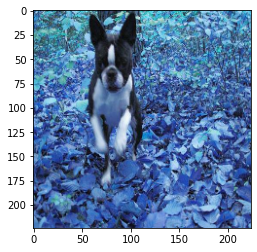

In [10]:
plt.imshow(features[0])
print (label[0])

In [11]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
label = encoder.fit_transform(label)

In [12]:
y=tf.keras.utils.to_categorical(label, 120)

In [13]:
features = np.array(features)
features = features.reshape(features.shape[0],features.shape[1],features.shape[2],features.shape[3])

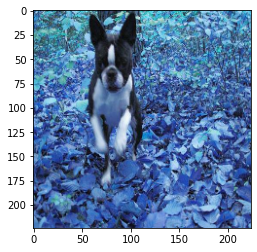

In [14]:
plt.imshow(features[0])

In [15]:
features.shape

(10222, 224, 224, 3)

In [16]:
def preprocess_input(x):
  return tf.keras.applications.resnet50.preprocess_input(x)

In [17]:
datagen= tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input,
                                                         width_shift_range=0.2,
                                                         height_shift_range=0.2,
                                                         rescale=1./255,
                                                         validation_split=0.3,
                                                         rotation_range=30,
                                                         shear_range=0.2,
                                                         zoom_range=0.3,
                                                         horizontal_flip=True,
                                                         vertical_flip=True)

In [18]:
#Build training generator. 
train_generator = datagen.flow(features,y,batch_size=32,subset='training',seed=42)

#Build validation generator
val_generator = datagen.flow(features,y,subset='validation',batch_size=32,seed=42)

In [19]:
base_model = tf.keras.applications.ResNet50(include_top=False,
                                            weights='imagenet',
                                            input_shape=(IMG_SIZE,IMG_SIZE,channels),
                                            pooling='max')
for layers in base_model.layers:
  layers.trainable=False

94773248/94765736 [==============================] - 1s 0us/step


In [20]:
x=base_model.output
x=tf.keras.layers.Dense(2048,activation='relu')(x)
x=tf.keras.layers.Dropout(rate=0.2)(x)
x=tf.keras.layers.Dense(1024,activation='relu')(x)
x=tf.keras.layers.Dropout(rate=0.2)(x)
x=tf.keras.layers.Dense(512,activation='relu')(x)
x=tf.keras.layers.Dropout(rate=0.2)(x)
x=tf.keras.layers.Dense(120,activation='softmax')(x)
model=tf.keras.Model(inputs=base_model.input,outputs=x)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [21]:
#Specify Loass and Optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
model_checkpoint=tf.keras.callbacks.ModelCheckpoint('dogbreed_cnn.h5', #where to save the model
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max',
                                                    min_delta=0.001,
                                                    patience=5,
                                                    verbose=1)
model_es=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',min_delta=0.001,patience=5,mode='max',verbose=1)
model_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=5,verbose=1,mode='auto',min_delta=0.0001)

In [23]:
history = model.fit(train_generator,
                    epochs=10,
                    steps_per_epoch= 7155//32,  #Number of training images//batch_size
                    validation_data=val_generator,
                    validation_steps = 3067//32, #Number of test images//batch_size
                    callbacks = [model_checkpoint,model_es,model_lr])

Epoch 1/10
223/223 [==============================] - ETA: 0s - loss: 4.8732 - accuracy: 0.0094
Epoch 00001: val_accuracy improved from -inf to 0.01250, saving model to dogbreed_cnn.h5
223/223 [==============================] - 118s 530ms/step - loss: 4.8732 - accuracy: 0.0094 - val_loss: 4.7854 - val_accuracy: 0.0125
Epoch 2/10
223/223 [==============================] - ETA: 0s - loss: 4.7862 - accuracy: 0.0101
Epoch 00002: val_accuracy did not improve from 0.01250
223/223 [==============================] - 113s 508ms/step - loss: 4.7862 - accuracy: 0.0101 - val_loss: 4.7879 - val_accuracy: 0.0099
Epoch 3/10
223/223 [==============================] - ETA: 0s - loss: 4.7820 - accuracy: 0.0108
Epoch 00003: val_accuracy did not improve from 0.01250
223/223 [==============================] - 114s 511ms/step - loss: 4.7820 - accuracy: 0.0108 - val_loss: 4.7831 - val_accuracy: 0.0095
Epoch 4/10
223/223 [==============================] - ETA: 0s - loss: 4.7806 - accuracy: 0.0094
Epoch 00004:

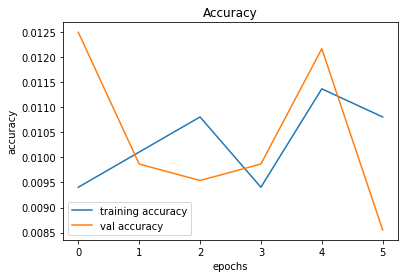

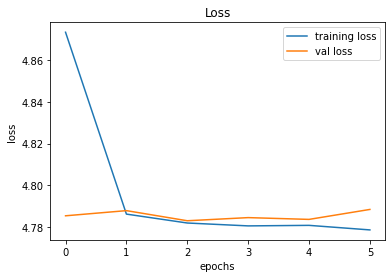

In [24]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()